# Skin Lesion Classification — Transfer Learning template
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```
If your dataset is packaged differently, adapt `train_dir` / `val_dir` variables below.

This notebook was autogenerated to match SE4050 assignment requirements (4 different model notebooks will be provided).
\n\n**Model:** MobileNetV3-Large

In [18]:
# Environment & imports
# If running in a fresh environment, you may need to install packages:
# !pip install torch torchvision matplotlib scikit-learn tqdm timm -q
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Note: you may need to restart the kernel to use updated packages.
Device: cpu


In [19]:
# Paths (change these to your dataset locations)
# Download and extract your dataset folders locally, then set the paths below:
train_dir = r"C:\Users\ashan\Downloads\DL-20251011T135953Z-1-001\DL\train"  # Example local path
val_dir   = r"C:\Users\ashan\Downloads\DL-20251011T135953Z-1-001\DL\val"    # Example local path

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [20]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129])


In [21]:
# MobileNetV3 Large (pretrained)
try:
    model = models.mobilenet_v3_large(pretrained=True)
    # Correctly identify the input features for the classifier
    num_ftrs = model.classifier[-1].in_features  # Access the last layer of the classifier
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # Fallback for older torchvision versions or different model structures
    model = models.mobilenet_v3_large(pretrained=True)
    # Attempt to access the in_features from the first layer if the above fails
    try:
        num_ftrs = model.classifier[0].in_features
        model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    except Exception as e_fallback:
        print(f"Could not adapt classifier automatically: {e_fallback}")
        print("Please check the model's classifier structure and adapt the code manually.")

model = model.to(device)

In [22]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 15  # change as needed


In [23]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=15, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [24]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="MobileNetV3-Large")


Epoch 1/15


100%|██████████| 333/333 [16:15<00:00,  2.93s/it]


train Loss: 1.1206 Acc: 0.5569 F1: 0.5288


100%|██████████| 42/42 [00:53<00:00,  1.26s/it]


val Loss: 0.6058 Acc: 0.7769 F1: 0.7513
------------------------------
Epoch 2/15


100%|██████████| 333/333 [15:13<00:00,  2.74s/it]


train Loss: 0.6329 Acc: 0.7349 F1: 0.7192


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]


val Loss: 0.4900 Acc: 0.8161 F1: 0.7813
------------------------------
Epoch 3/15


100%|██████████| 333/333 [14:00<00:00,  2.52s/it]


train Loss: 0.4926 Acc: 0.7879 F1: 0.7791


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


val Loss: 0.3152 Acc: 0.8794 F1: 0.8814
------------------------------
Epoch 4/15


100%|██████████| 333/333 [15:26<00:00,  2.78s/it]


train Loss: 0.4135 Acc: 0.8277 F1: 0.8136


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


val Loss: 0.2926 Acc: 0.8847 F1: 0.8652
------------------------------
Epoch 5/15


100%|██████████| 333/333 [16:03<00:00,  2.89s/it]


train Loss: 0.3732 Acc: 0.8503 F1: 0.8360


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


val Loss: 0.2196 Acc: 0.9148 F1: 0.8824
------------------------------
Epoch 6/15


100%|██████████| 333/333 [16:07<00:00,  2.91s/it]


train Loss: 0.3530 Acc: 0.8597 F1: 0.8446


100%|██████████| 42/42 [00:48<00:00,  1.15s/it]


val Loss: 0.2339 Acc: 0.9156 F1: 0.8957
------------------------------
Epoch 7/15


100%|██████████| 333/333 [16:07<00:00,  2.91s/it]


train Loss: 0.3207 Acc: 0.8738 F1: 0.8589


100%|██████████| 42/42 [00:49<00:00,  1.18s/it]


val Loss: 0.1746 Acc: 0.9382 F1: 0.9151
------------------------------
Epoch 8/15


100%|██████████| 333/333 [16:07<00:00,  2.91s/it]


train Loss: 0.2821 Acc: 0.8906 F1: 0.8779


100%|██████████| 42/42 [00:47<00:00,  1.14s/it]


val Loss: 0.1735 Acc: 0.9314 F1: 0.9114
------------------------------
Epoch 9/15


100%|██████████| 333/333 [16:08<00:00,  2.91s/it]


train Loss: 0.2723 Acc: 0.8862 F1: 0.8748


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


val Loss: 0.1516 Acc: 0.9427 F1: 0.9246
------------------------------
Epoch 10/15


100%|██████████| 333/333 [16:09<00:00,  2.91s/it]


train Loss: 0.2618 Acc: 0.8970 F1: 0.8838


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


val Loss: 0.1503 Acc: 0.9420 F1: 0.9285
------------------------------
Epoch 11/15


100%|██████████| 333/333 [16:11<00:00,  2.92s/it]


train Loss: 0.2379 Acc: 0.9035 F1: 0.8961


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


val Loss: 0.1562 Acc: 0.9442 F1: 0.9268
------------------------------
Epoch 12/15


100%|██████████| 333/333 [16:07<00:00,  2.91s/it]


train Loss: 0.2377 Acc: 0.9024 F1: 0.8940


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


val Loss: 0.1339 Acc: 0.9525 F1: 0.9262
------------------------------
Epoch 13/15


100%|██████████| 333/333 [16:09<00:00,  2.91s/it]


train Loss: 0.2216 Acc: 0.9113 F1: 0.9040


100%|██████████| 42/42 [00:49<00:00,  1.18s/it]


val Loss: 0.1308 Acc: 0.9510 F1: 0.9376
------------------------------
Epoch 14/15


100%|██████████| 333/333 [16:08<00:00,  2.91s/it]


train Loss: 0.2155 Acc: 0.9134 F1: 0.9086


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


val Loss: 0.1202 Acc: 0.9578 F1: 0.9455
------------------------------
Epoch 15/15


100%|██████████| 333/333 [16:11<00:00,  2.92s/it]


train Loss: 0.1962 Acc: 0.9217 F1: 0.9165


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]

val Loss: 0.1257 Acc: 0.9578 F1: 0.9305
------------------------------
Training complete in 250m 54s
Best val F1: 0.9455


In [25]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


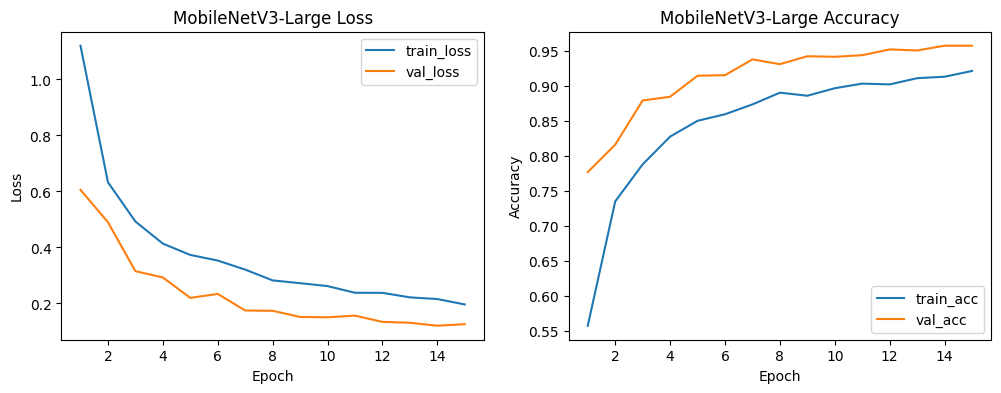

In [26]:
plot_history(history, model_name="MobileNetV3-Large")


In [43]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    
    # Fix sklearn warnings by setting zero_division parameter
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

In [28]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.87      0.87      0.87        86
             Chickenpox       0.96      0.98      0.97       112
                 Cowpox       0.99      0.96      0.97        99
         Dermatofibroma       0.96      0.96      0.96        23
                   HFMD       0.93      1.00      0.97       241
                Healthy       0.98      0.98      0.98       171
                Measles       1.00      0.94      0.97        82
              Monkeypox       0.98      0.96      0.97       426
Squamous cell carcinoma       0.82      0.81      0.81        62
       Vascular lesions       0.96      1.00      0.98        25

               accuracy                           0.96      1327
              macro avg       0.95      0.95      0.95      1327
           weighted avg       0.96      0.96      0.96      1327

Confusion matrix:
 [[ 75   0   0   0   0   0   0   0  11   0]
 [  0 110   0   0   0   0

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 1337

Test set class distribution:
  Actinic keratoses: 88
  Chickenpox: 113
  Cowpox: 99
  Dermatofibroma: 25
  HFMD: 242
  Healthy: 171
  Measles: 83
  Monkeypox: 426
  Squamous cell carcinoma: 64
  Vascular lesions: 26
⚠️ Checkpoint load failed (using current model): Error(s) in loading state_dict for MobileNetV3:
	size mismatch for classifier.3.weight: copying a param with shape torch.Size([10, 1280]) from checkpoint, the shape in current model is torch.Size([11, 1280]).
	size mismatch for classifier.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([11]).

TEST SET EVALUATION RESULTS
Overall Accuracy: 0.119
F1 Score (Macro): 0.059
F1 Score (Weighted): 0.087

Detailed Classifi

C:\Users\ashan\AppData\Local\Temp\ipykernel_20016\1205800131.py:94: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


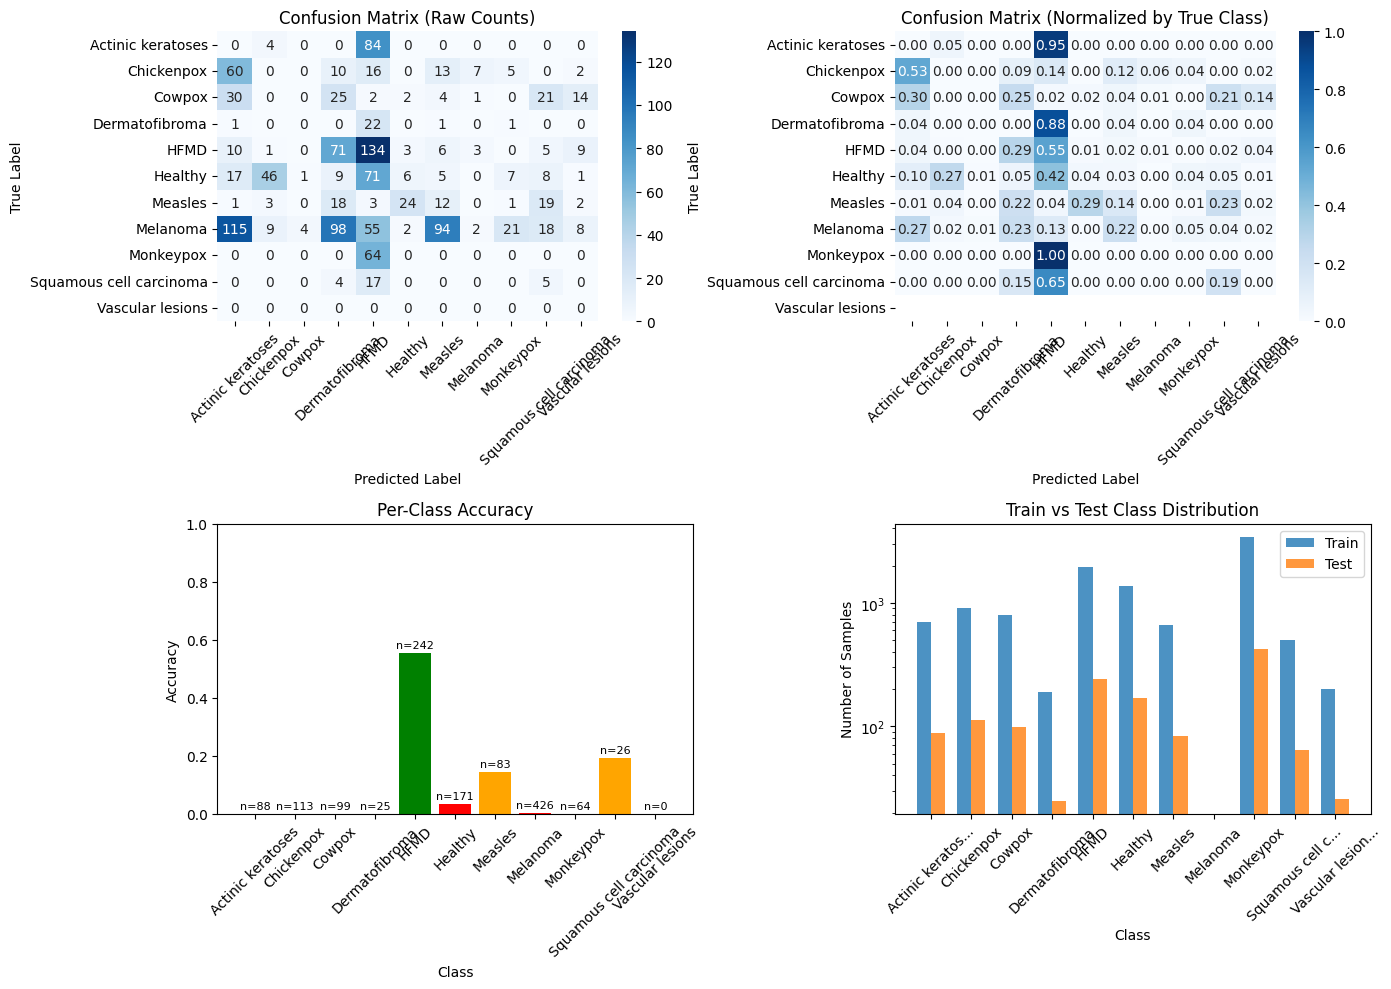


DIAGNOSTIC INFORMATION

Classes with poor performance (accuracy < 0.1):
  Actinic keratoses: 0.000 accuracy, 88 samples
  Chickenpox: 0.000 accuracy, 113 samples
  Cowpox: 0.000 accuracy, 99 samples
  Dermatofibroma: 0.000 accuracy, 25 samples
  Healthy: 0.035 accuracy, 171 samples
  Melanoma: 0.005 accuracy, 426 samples
  Monkeypox: 0.000 accuracy, 64 samples
  Vascular lesions: No test samples available

Model's prediction bias (most frequently predicted classes):
  HFMD: 468 predictions (35.0%)
  Dermatofibroma: 235 predictions (17.6%)
  Actinic keratoses: 234 predictions (17.5%)
  Measles: 135 predictions (10.1%)
  Squamous cell carcinoma: 76 predictions (5.7%)

Suggestions for improvement:
1. The model appears to be heavily biased toward certain classes (especially HFMD)
2. Consider data augmentation or resampling for underrepresented classes
3. Adjust class weights more aggressively
4. Consider using focal loss instead of weighted cross-entropy
5. Ensure test set class distribut

In [45]:
# Test Set Evaluation with Improved Error Handling
%pip install pandas seaborn
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# path to test data 
test_dir = r"C:\Users\ashan\Downloads\DL-20251011T135953Z-1-001\DL\test"
# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# Check class distribution in test set
test_class_counts = {}
for _, label in test_dataset.samples:
    class_name = test_dataset.classes[label]
    test_class_counts[class_name] = test_class_counts.get(class_name, 0) + 1

print("\nTest set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")

# load best checkpoint (if you saved it during training)
ckpt_path = "MobileNetV3-Large_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print(f"\n✅ Loaded checkpoint: {ckpt_path}")
except Exception as e:
    print(f"⚠️ Checkpoint load failed (using current model): {e}")

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# Calculate metrics with zero_division parameter to fix warnings
print("\n" + "="*50)
print("TEST SET EVALUATION RESULTS")
print("="*50)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Overall Accuracy: {accuracy:.3f}")
print(f"F1 Score (Macro): {f1_macro:.3f}")
print(f"F1 Score (Weighted): {f1_weighted:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Raw Confusion Matrix:")
print(cm)

# Enhanced confusion matrix visualization
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
# Use seaborn for better heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(2, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Class-wise performance analysis
plt.subplot(2, 2, 3)
class_accuracies = []
class_support = []
for i in range(len(class_names)):
    if cm[i].sum() > 0:  # Only if class has samples
        class_acc = cm[i, i] / cm[i].sum()
        class_accuracies.append(class_acc)
        class_support.append(cm[i].sum())
    else:
        class_accuracies.append(0)
        class_support.append(0)

bars = plt.bar(range(len(class_names)), class_accuracies, 
               color=['red' if acc < 0.1 else 'orange' if acc < 0.5 else 'green' 
                      for acc in class_accuracies])
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)

# Add support numbers on bars
for i, (bar, support) in enumerate(zip(bars, class_support)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'n={support}', ha='center', va='bottom', fontsize=8)

# Class distribution comparison
plt.subplot(2, 2, 4)
class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in class_names]
# Get train counts from train_dataset if available
if 'train_dataset' in globals():
    train_class_counts = {}
    for _, label in train_dataset.samples:
        class_name = train_dataset.classes[label]
        train_class_counts[class_name] = train_class_counts.get(class_name, 0) + 1
    train_counts = [train_class_counts.get(class_names[i], 0) for i in range(len(class_names))]
else:
    train_counts = [0] * len(class_names)
test_counts = [test_class_counts.get(class_names[i], 0) for i in range(len(class_names))]

x = np.arange(len(class_names))
width = 0.35
plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.title("Train vs Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(x, class_names_short, rotation=45)
plt.legend()
plt.yscale('log')  # Log scale to better show differences

plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n" + "="*50)
print("DIAGNOSTIC INFORMATION")
print("="*50)

print("\nClasses with poor performance (accuracy < 0.1):")
for i, (class_name, acc, support) in enumerate(zip(class_names, class_accuracies, class_support)):
    if acc < 0.1 and support > 0:
        print(f"  {class_name}: {acc:.3f} accuracy, {support} samples")
    elif support == 0:
        print(f"  {class_name}: No test samples available")

print("\nModel's prediction bias (most frequently predicted classes):")
pred_counts = np.bincount(y_pred, minlength=len(class_names))
for i in np.argsort(pred_counts)[::-1][:5]:  # Top 5 most predicted
    print(f"  {class_names[i]}: {pred_counts[i]} predictions ({pred_counts[i]/len(y_pred)*100:.1f}%)")

print("\nSuggestions for improvement:")
print("1. The model appears to be heavily biased toward certain classes (especially HFMD)")
print("2. Consider data augmentation or resampling for underrepresented classes")
print("3. Adjust class weights more aggressively")
print("4. Consider using focal loss instead of weighted cross-entropy")
print("5. Ensure test set class distribution matches expected real-world distribution")

# Save detailed results
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": [os.path.basename(f) for f in filenames],  # Just filename, not full path
    "true_label": [class_names[i] for i in y_true],
    "pred_label": [class_names[i] for i in y_pred],
    "confidence": [round(float(np.max(p)), 4) for p in probs],
    "correct": [t == p for t, p in zip(y_true, y_pred)]
})

# Add per-class confidence statistics
df.to_csv("test_predictions_detailed.csv", index=False)
print(f"\n✅ Saved detailed predictions to: test_predictions_detailed.csv")

# Summary of misclassifications
print(f"\nMisclassification summary:")
misclassified = df[~df['correct']]
if len(misclassified) > 0:
    print(f"Total misclassified: {len(misclassified)}/{len(df)} ({len(misclassified)/len(df)*100:.1f}%)")
    print("Most common misclassifications:")
    misclass_pairs = misclassified.groupby(['true_label', 'pred_label']).size().sort_values(ascending=False)
    for (true_label, pred_label), count in misclass_pairs.head(10).items():
        print(f"  {true_label} → {pred_label}: {count} cases")
else:
    print("Perfect classification! (This is unlikely - please verify your data)")

## Notes and next steps
- Tune learning rates, batch size, augmentation.
- Consider 5-fold cross validation for robustness.
- Use mixed precision (torch.cuda.amp) to speed up training on large GPUs.
- Save final models and record results in a comparison table.